In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [2]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake_df = fake_df[['title', 'text']]
real_df = real_df[['title', 'text']]

fake_df['class'] = 1
real_df['class'] = 0

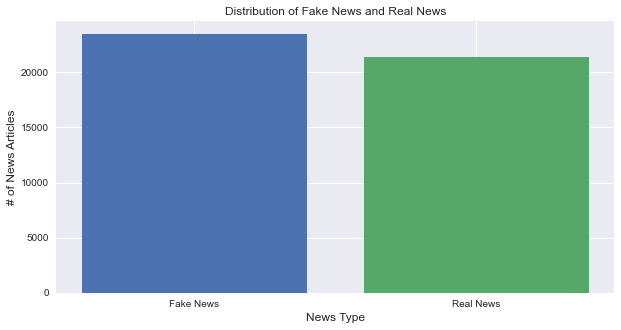

In [5]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df))
plt.bar('Real News', len(real_df))
plt.title('Distribution of Fake News and Real News', size=12)
plt.xlabel('News Type', size=12)
plt.ylabel('# of News Articles', size=12);

Here we can see that there is more fake news than there is real news in the dataset. 

In [6]:
df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
df.head()

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1


In [7]:
df['title_text'] = df['title'] + ' ' + df['text']
df.drop(['title', 'text'], axis=1, inplace=True)
df.head()

,class,title_text
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...


I am only going to combine the title and the text to have only one field with all the information. 

# Baseline Model Testing

In [8]:
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
df_log = df.copy()

In [10]:
def preprocessor(text):

    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()

    return text

df_log['title_text'] = df_log['title_text'].apply(preprocessor)

In [11]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [12]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

X = tfidf.fit_transform(df_log['title_text'])
y = df_log['class'].values

## Build a classification model using various methods

In [13]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [14]:
model_params = {

    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'C': [1,5,10],
            'solver':['newton-cg', 'liblinear']
        }
    },

    'kneighbours': {
        'model': KNeighborsClassifier(n_jobs=-1),
        "params": {
            
            'n_neighbors' : [5, 10 , 100],
        }
    },

}

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
scores = []

for model_name, mp in model_params.items():
    print(model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_.round(4),
        'best_params': clf.best_params_
    })

logistic_regression
kneighbours


In [16]:
rel = pd.DataFrame(scores,columns=['model','best_score','best_params'])
rel.sort_values('best_score', ascending=False)

,model,best_score,best_params
0,logistic_regression,0.9905,"{'C': 10, 'solver': 'newton-cg'}"
1,kneighbours,0.8309,{'n_neighbors': 100}


The results from the table tells us that we should use logistic regression with the following best parameters.

## Using the best model as baseline

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [19]:
model = LogisticRegression(multi_class='auto', C=10, solver='newton-cg')
model.fit(X_train, y_train)

LogisticRegression(C=10, solver='newton-cg')

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.9944320712694877
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4284
           1       1.00      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



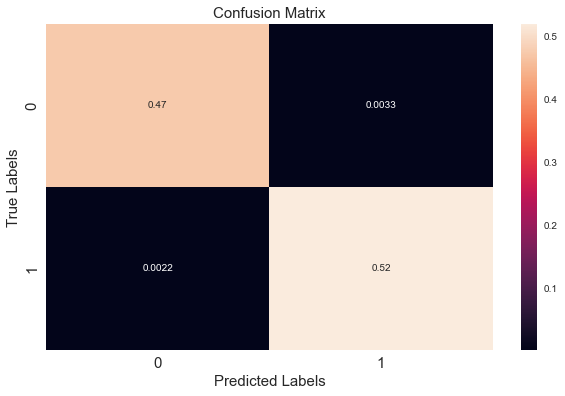

In [21]:
import seaborn as sns

matrix = confusion_matrix(y_pred, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

Using a simple logistic regression gives a high accuracy, precision and recall score. Furthermore, the confusion matrix, shows that less than 1% of the classes were labeled incorrectly.  

# Keras

In [22]:
import tensorflow as tf

In [23]:
X = df['title_text']
y = df['class']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [25]:
import re

def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [26]:
vocab_size = 10000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [28]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [33]:
input_dim = X_train.shape[1]

## Dense

### Simple

In [35]:
model = tf.keras.models.Sequential([

tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
tf.keras.layers.Dropout(0.25, name="dropout"),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,025
Trainable params: 33,025
Non-trainable params: 0
_________________________________________________________________


In [36]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [37]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1011/1011 [==============================] - 2s 2ms/step - loss: 456.6195 - accuracy: 0.5217 - precision: 0.5423 - recall: 0.5562 - val_loss: 217.5519 - val_accuracy: 0.5428 - val_precision: 0.5592 - val_recall: 0.5405
Epoch 2/10
1011/1011 [==============================] - 2s 2ms/step - loss: 221.2900 - accuracy: 0.5431 - precision: 0.5627 - recall: 0.5722 - val_loss: 129.9959 - val_accuracy: 0.5463 - val_precision: 0.5595 - val_recall: 0.5704
Epoch 3/10
1011/1011 [==============================] - 2s 2ms/step - loss: 116.6033 - accuracy: 0.5491 - precision: 0.5686 - recall: 0.5758 - val_loss: 68.8535 - val_accuracy: 0.5433 - val_precision: 0.5545 - val_recall: 0.5877
Epoch 4/10
1011/1011 [==============================] - 2s 2ms/step - loss: 54.5086 - accuracy: 0.5596 - precision: 0.5783 - recall: 0.5872 - val_loss: 31.6586 - val_accuracy: 0.5469 - val_precision: 0.5578 - val_recall: 0.5906
Epoch 5/10
1011/1011 [==============================] - 2s 2ms/step - loss: 22.5705 - accuracy

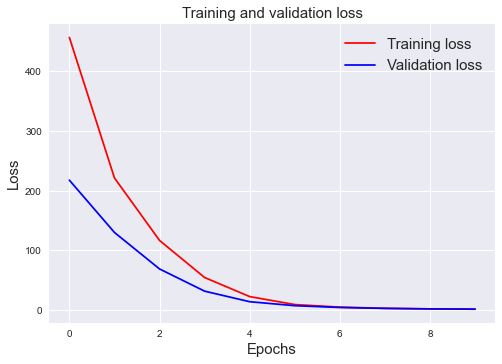

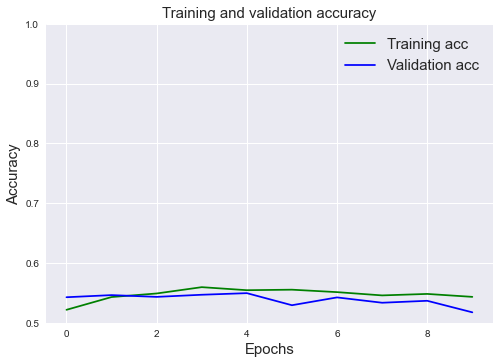

In [38]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [39]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

---Test Set Results---
Accuracy: 0.5394209354120267
              precision    recall  f1-score   support

         0.0       0.52      0.48      0.50      5354
         1.0       0.56      0.60      0.57      5871

    accuracy                           0.54     11225
   macro avg       0.54      0.54      0.54     11225
weighted avg       0.54      0.54      0.54     11225



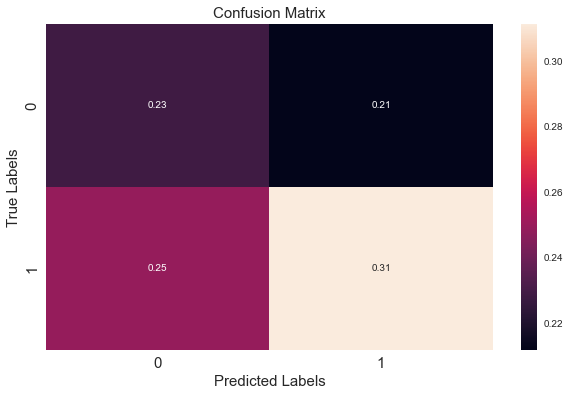

In [40]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

Just using a dense layer is not good enough as the scores are acceptable but not as high as the baseline model.

### Embedding

In [51]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
tf.keras.layers.Dropout(0.25, name="dropout"),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 256, 64)           640000    
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               2097280   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,737,409
Trainable params: 2,737,409
Non-trainable params: 0
_________________________________________________________________


In [52]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [53]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1011/1011 [==============================] - 16s 15ms/step - loss: 0.1788 - accuracy: 0.9403 - precision: 0.9459 - recall: 0.9398 - val_loss: 0.0142 - val_accuracy: 0.9988 - val_precision: 0.9983 - val_recall: 0.9994
Epoch 2/10
1011/1011 [==============================] - 16s 16ms/step - loss: 0.0076 - accuracy: 0.9989 - precision: 0.9986 - recall: 0.9993 - val_loss: 0.0047 - val_accuracy: 0.9997 - val_precision: 0.9994 - val_recall: 1.0000
Epoch 3/10
1011/1011 [==============================] - 16s 16ms/step - loss: 0.0019 - accuracy: 0.9999 - precision: 0.9999 - recall: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9997 - val_precision: 0.9994 - val_recall: 1.0000
Epoch 4/10
1011/1011 [==============================] - 16s 16ms/step - loss: 8.7498e-04 - accuracy: 1.0000 - precision: 0.9999 - recall: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9997 - val_precision: 0.9994 - val_recall: 1.0000
Epoch 5/10
1011/1011 [==============================] - 16s 16ms/step - loss: 5.2136

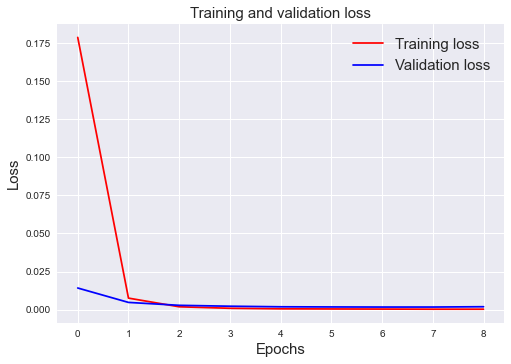

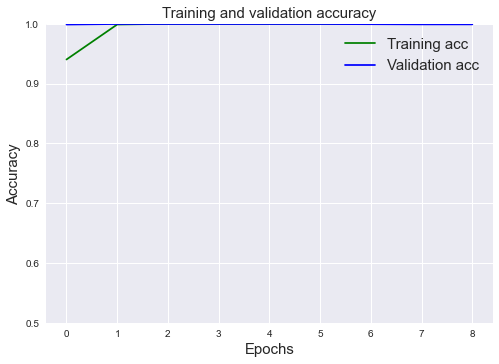

In [54]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [55]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

---Test Set Results---
Accuracy: 0.9984855233853007
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5354
         1.0       1.00      1.00      1.00      5871

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



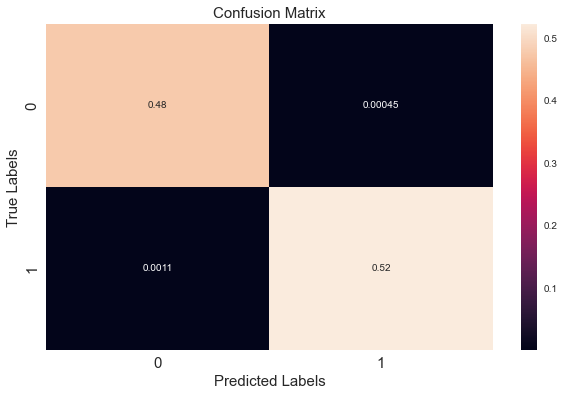

In [56]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

Adding an embedding layer, and the scores are just as good as the baseline model. The embedding layer helps in dimensionality reduction over one-hot encoding and it is also capable of understanding the context of a word so that similar words have similar embeddings.

## LSTM

In [57]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
tf.keras.layers.Dropout(0.1, name="dropout"),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 256, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 256, 128)         66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 747,329
Trainable params: 747,329
Non-tr

In [58]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [59]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1011/1011 [==============================] - 305s 297ms/step - loss: 0.1505 - accuracy: 0.9350 - precision: 0.9108 - recall: 0.9711 - val_loss: 0.0306 - val_accuracy: 0.9938 - val_precision: 0.9994 - val_recall: 0.9885
Epoch 2/10
1011/1011 [==============================] - 304s 301ms/step - loss: 0.0156 - accuracy: 0.9972 - precision: 0.9974 - recall: 0.9972 - val_loss: 0.0082 - val_accuracy: 0.9994 - val_precision: 0.9989 - val_recall: 1.0000
Epoch 3/10
1011/1011 [==============================] - 305s 302ms/step - loss: 0.0070 - accuracy: 0.9991 - precision: 0.9987 - recall: 0.9996 - val_loss: 0.0094 - val_accuracy: 0.9979 - val_precision: 0.9988 - val_recall: 0.9971
Epoch 4/10
1011/1011 [==============================] - 302s 299ms/step - loss: 0.0030 - accuracy: 0.9996 - precision: 0.9994 - recall: 0.9998 - val_loss: 0.0097 - val_accuracy: 0.9979 - val_precision: 0.9994 - val_recall: 0.9965


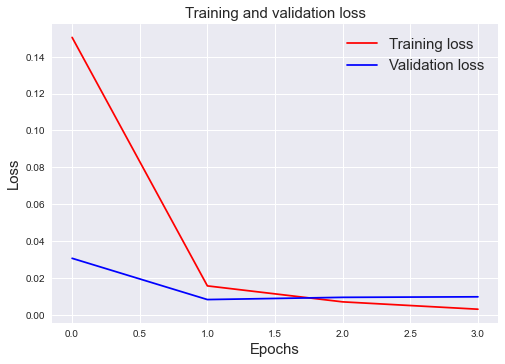

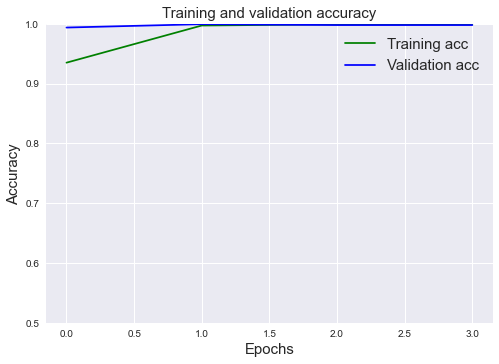

In [60]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [61]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

---Test Set Results---
Accuracy: 0.9956347438752784
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5354
         1.0       0.99      1.00      1.00      5871

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



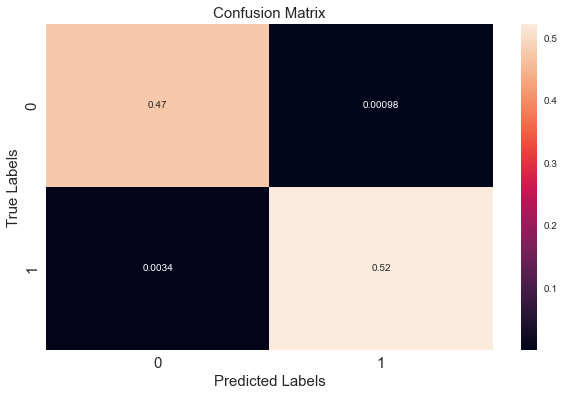

In [62]:
import seaborn as sns

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

This model has the same results as the dense model with embedding, but a longer run time. 

# Conclusion

Overall, using a neural network is not a very efficient approach to solving this problem. The logisitic model gives very high accuracy but only half the run time, so it is very important to have a simple model first 